# Imports & loading

In [1]:
# conda install pytorch torchvision torchaudio -c pytorch
# conda activate DDAI_311


In [2]:
# %pip install torch==2.7.0 torchvision==0.22.0 torchaudio==2.7.0

In [3]:
from support import load_dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from tqdm.notebook import tqdm 

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
import torch, gc, os

def get_device():
    if torch.backends.mps.is_available():         # Apple GPU
        return torch.device("mps")
    elif torch.cuda.is_available():               # NVIDIA eGPU etc.
        return torch.device("cuda")
    else:                                         # fallback
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")
torch.set_float32_matmul_precision("high")        # speeds M-series matmul
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"   # CPU fallback for missing ops


Using device: mps


#### Print Python and PyTorch version

In [6]:
print("Python version:", os.sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Python version: 3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
PyTorch version: 2.7.0
CUDA available: False


In [7]:
import torch, time
x = torch.randn(8192, 8192, device='mps')
t0 = time.perf_counter()
y = x @ x.T
torch.mps.synchronize()     # wait for GPU
print("took %.2f s" % (time.perf_counter() - t0))


took 0.29 s


In [8]:
data = load_dataset()
train_dataset = data[0]
test_dataset = data[1]

In [9]:
img, label = train_dataset[0]

print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Train_dataset: {train_dataset}")

Image shape: torch.Size([3, 60, 30])
Label: 0
Train_dataset: Dataset ImageFolder
    Number of datapoints: 136
    Root location: WF-data/train
    StandardTransform
Transform: Compose(
               Resize(size=[105, 78], interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=[60, 30])
               ToTensor()
           )


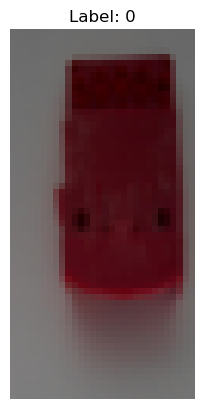

In [10]:
img_tensor, label = train_dataset[0]
transform_to_pil = T.ToPILImage()
img_pil = transform_to_pil(img_tensor)

plt.imshow(img_pil)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# CNN

## Base Model

In [11]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16 x H/2 x W/2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: 32 x H/4 x W/4
        )
        
        # Calculate the flattened size dynamically to connect conv layers to fc layers
        with torch.no_grad(): # We don't need gradients for this calculation
            dummy_input = torch.zeros(1, input_channels, input_height, input_width)
            flattened_size = self.conv_layers(dummy_input).flatten(1).shape[1]
            
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            # Output 1 logit for binary classification (labels 0 or 1)
            # This will be used with BCEWithLogitsLoss
            nn.Linear(128, 1 if num_classes == 2 else num_classes) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1) # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [ ]:
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameters
learning_rate = 0.007
batch_size = 8 # Adjust this based on memory
num_epochs = 10  # Adjust as needed for convergence
num_classes = 2  # Binary classification (labels 0 and 1)

# Model, Loss, Optimizer
device = get_device()
print(f"Using device: {device}")

# DataLoaders
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes).to(device)
# model = torch.compile(model)

# Binary Cross Entropy with Logits Loss, suitable for binary classification with one output neuron
criterion = nn.BCEWithLogitsLoss() # Different choiches possible
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    model.train()  
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        # Reshape labels to [batch_size, 1] and convert to float for BCEWithLogitsLoss
        labels = labels.to(device).float().unsqueeze(1) 

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % max(1, len(train_loader) // 10) == 0: # Print progress, e.g. 10 times per epoch
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    avg_epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Training Loss: {avg_epoch_loss:.4f}")

    # Evaluation on the test set
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1) #
            
            # predictions on the test set
            outputs = model(images)
            predictions = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predictions == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

    if device.type == "mps":            # Apple-GPU path
        torch.mps.empty_cache()
    elif device.type == "cuda":         # NVIDIA-GPU path
        torch.cuda.empty_cache()
    gc.collect() 

    
# Save the model
model_path = "simple_cnn_model.pth"
torch.save(model.state_dict(), model_path)
print("Finished Training")
print(f"Model saved to {model_path}")

Detected image shape: Channels=3, Height=60, Width=30
Using device: mps


Training Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch [1/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 1: 50.00%
Epoch [2/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 2: 50.00%
Epoch [3/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 3: 50.00%
Epoch [4/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 4: 50.00%
Epoch [5/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 5: 50.00%
Epoch [6/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 6: 50.00%
Epoch [7/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 7: 50.00%
Epoch [8/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 8: 50.00%
Epoch [9/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 9: 50.00%
Epoch [10/10] completed. Average Training Loss: 0.0000
Accuracy on test set after epoch 10: 50.00%
Finished Training
Model save

## Increased complexity

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes,
                 conv1_out_channels=16, conv2_out_channels=32, fc_neurons=128):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, conv1_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: conv1_out_channels x H/2 x W/2
            nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Output: conv2_out_channels x H/4 x W/4
        )
        
        # Calculate the flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, input_height, input_width)
            flattened_size = self.conv_layers(dummy_input).flatten(1).shape[1]
            
        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, fc_neurons),
            nn.ReLU(),
            nn.Linear(fc_neurons, 1 if num_classes == 2 else num_classes) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1) # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [14]:
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameters (Base Model)
learning_rate = 0.001
batch_size = 8 
num_epochs = 20 
num_classes = 2 

# Default architectural parameters for the base model
conv1_out_channels_base = 16
conv2_out_channels_base = 32
fc_neurons_base = 128

# Model, Loss, Optimizer
device = get_device()
print(f"Using device: {device}")

# DataLoaders
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)

# Use the (potentially modified) SimpleCNN class
model = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes,
                    conv1_out_channels=conv1_out_channels_base, 
                    conv2_out_channels=conv2_out_channels_base, 
                    fc_neurons=fc_neurons_base).to(device)
# model = torch.compile(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store metrics for plotting
epoch_train_losses = []
epoch_test_accuracies = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):
    model.train()  
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1) 

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0) # loss.item() is avg loss for batch
    
    avg_epoch_loss = running_loss / len(train_loader.dataset)  # Average loss over the entire training set
    epoch_train_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Training Loss: {avg_epoch_loss:.4f}")

    # Evaluation on the test set
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            outputs = model(images)
            predicted = (torch.sigmoid(outputs) > 0.5).float() 
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    epoch_test_accuracies.append(accuracy)
    print(f"Accuracy on test set after epoch {epoch+1}: {accuracy:.2f}%")

    if device.type == "mps":            # Apple-GPU path
        torch.mps.empty_cache()
    elif device.type == "cuda":         # NVIDIA-GPU path
        torch.cuda.empty_cache()
    gc.collect()                        # reclaim Python-held objects

print("Finished Training Base Model")

Detected image shape: Channels=3, Height=60, Width=30
Using device: mps


Training Progress:   0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch [1/20] completed. Average Training Loss: 0.6955
Accuracy on test set after epoch 1: 50.00%
Epoch [2/20] completed. Average Training Loss: 0.6921
Accuracy on test set after epoch 2: 70.59%
Epoch [3/20] completed. Average Training Loss: 0.6827
Accuracy on test set after epoch 3: 61.76%
Epoch [4/20] completed. Average Training Loss: 0.6775
Accuracy on test set after epoch 4: 61.76%
Epoch [5/20] completed. Average Training Loss: 0.6195
Accuracy on test set after epoch 5: 61.76%
Epoch [6/20] completed. Average Training Loss: 0.5475
Accuracy on test set after epoch 6: 70.59%
Epoch [7/20] completed. Average Training Loss: 0.4780
Accuracy on test set after epoch 7: 73.53%
Epoch [8/20] completed. Average Training Loss: 0.4218
Accuracy on test set after epoch 8: 76.47%
Epoch [9/20] completed. Average Training Loss: 0.3970
Accuracy on test set after epoch 9: 64.71%
Epoch [10/20] completed. Average Training Loss: 0.3961
Accuracy on test set after epoch 10: 70.59%
Epoch [11/20] completed. Ave

### Plots

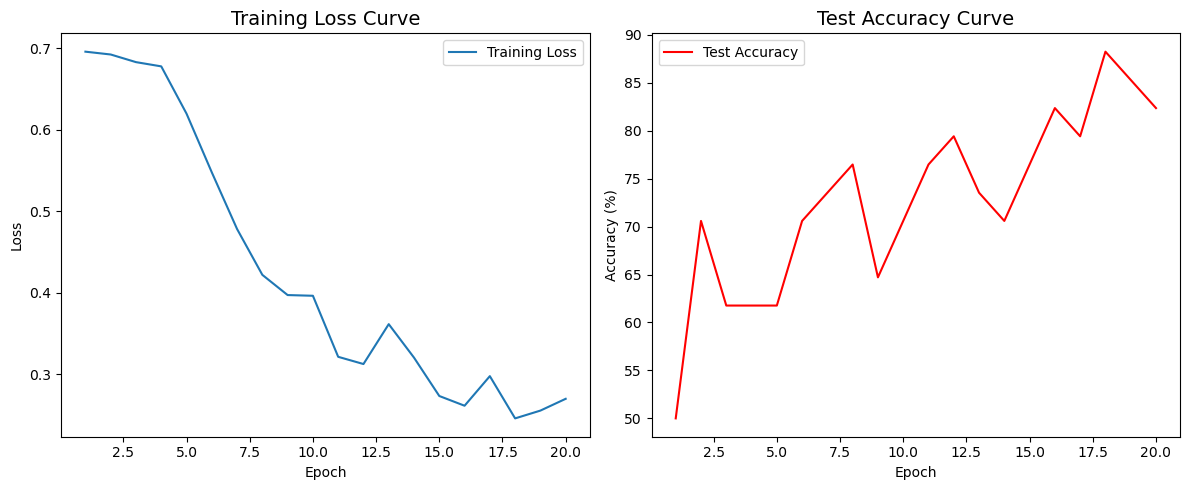

In [15]:
# Plotting learning curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve', fontsize=14)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Hyperparameter tuning

### Random Search

In [18]:
# Device configuration
device = get_device()
print(f"Using device for hyperparameter tuning: {device}")

# Get image dimensions (C, H, W should be available from the previous cell or re-derived)
if 'C' not in locals() or 'H' not in locals() or 'W' not in locals():
    sample_img, _ = train_dataset[0]
    C, H, W = sample_img.shape
    print(f"Re-detected image shape: Channels={C}, Height={H}, Width={W}")

# Hyperparameter search space
param_space = {
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'batch_size': [8, 16, 32],
    'conv1_out_channels': [8, 16, 32],
    'conv2_out_channels': [16, 32, 64],
    'fc_neurons': [64, 128, 256],
}

num_classes_hp = 2
num_epochs_search = 20 # Fewer epochs for faster search, adjust as needed
num_trials = 20 # Number of random hyperparameter sets to try

best_hyperparams = None
best_val_accuracy = -1.0
best_model_state = None

# Store history for the best model's learning curves
best_model_train_losses = []
best_model_val_accuracies = []

for trial in tqdm(range(num_trials), desc="Hyperparameter Search Trials", unit="trial"):
    # Randomly sample hyperparameters
    current_params = {k: random.choice(v) for k, v in param_space.items()}
    print(f"Testing params: {current_params}")

    # DataLoaders with current batch size
    pin_memory_flag   = device.type == 'cuda'
    num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

    try:
        current_train_loader = DataLoader(train_dataset, batch_size=current_params['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
        current_val_loader = DataLoader(test_dataset, batch_size=current_params['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    except Exception as e:
        print(f"Error creating DataLoader, possibly due to batch size: {e}. Skipping trial.")
        continue


    # Model
    model_hp = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                            conv1_out_channels=current_params['conv1_out_channels'],
                            conv2_out_channels=current_params['conv2_out_channels'],
                            fc_neurons=current_params['fc_neurons']).to(device)
    # model_hp = torch.compile(model_hp)

    criterion_hp = nn.BCEWithLogitsLoss()
    
    optimizer_hp = optim.Adam(model_hp.parameters(), lr=current_params['learning_rate'])

    trial_train_losses = []
    trial_val_accuracies = []

    # Training loop
    for epoch in tqdm(range(num_epochs_search), desc=f"Trial {trial+1} Training", leave=False):
        model_hp.train()
        epoch_running_loss = 0.0
        for images, labels in current_train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer_hp.zero_grad()
            outputs = model_hp(images)
            loss = criterion_hp(outputs, labels)
            loss.backward()
            optimizer_hp.step()
            epoch_running_loss += loss.item() * images.size(0)
        
        avg_epoch_train_loss = epoch_running_loss / len(current_train_loader.dataset)
        trial_train_losses.append(avg_epoch_train_loss)

        # Validation
        model_hp.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in current_val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model_hp(images)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        current_epoch_val_accuracy = 100 * val_correct / val_total
        trial_val_accuracies.append(current_epoch_val_accuracy)
        
        print(f"Trial {trial+1} Epoch {epoch+1}: Train Loss: {avg_epoch_train_loss:.4f}, Val Accuracy: {current_epoch_val_accuracy:.2f}%")

        if device.type == "mps":            # Apple-GPU path
            torch.mps.empty_cache()
        elif device.type == "cuda":         # NVIDIA-GPU path
            torch.cuda.empty_cache()
        gc.collect()                        # reclaim Python-held objects
        
    # Check if this trial is the best so far (based on final epoch's validation accuracy)
    if trial_val_accuracies and current_epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = current_epoch_val_accuracy
        best_hyperparams = current_params
        best_model_state = model_hp.state_dict() # Save the model state
        best_model_train_losses = trial_train_losses # Save learning curves for this best model
        best_model_val_accuracies = trial_val_accuracies
        print(f"New best model found! Val Accuracy: {best_val_accuracy:.2f}%, Params: {best_hyperparams}")

print("\nFinished Hyperparameter Search.")

# Save the best model found during hyperparameter search
best_randomsearch_model_path = "best_randomsearch_cnn_model.pth"
torch.save(best_model_state, best_randomsearch_model_path)
print(f"Best randomsearch model saved to {best_randomsearch_model_path}")
   

Using device for hyperparameter tuning: mps


Hyperparameter Search Trials:   0%|          | 0/20 [00:00<?, ?trial/s]

Testing params: {'learning_rate': 0.01, 'batch_size': 32, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 128}


Trial 1 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 1 Epoch 1: Train Loss: 1.2938, Val Accuracy: 50.00%
Trial 1 Epoch 2: Train Loss: 0.7113, Val Accuracy: 50.00%
Trial 1 Epoch 3: Train Loss: 0.6929, Val Accuracy: 50.00%
Trial 1 Epoch 4: Train Loss: 0.6937, Val Accuracy: 50.00%
Trial 1 Epoch 5: Train Loss: 0.6906, Val Accuracy: 50.00%
Trial 1 Epoch 6: Train Loss: 0.6887, Val Accuracy: 50.00%
Trial 1 Epoch 7: Train Loss: 0.6735, Val Accuracy: 50.00%
Trial 1 Epoch 8: Train Loss: 0.6528, Val Accuracy: 61.76%
Trial 1 Epoch 9: Train Loss: 0.5827, Val Accuracy: 79.41%
Trial 1 Epoch 10: Train Loss: 0.4611, Val Accuracy: 50.00%
Trial 1 Epoch 11: Train Loss: 0.7405, Val Accuracy: 79.41%
Trial 1 Epoch 12: Train Loss: 0.5415, Val Accuracy: 76.47%
Trial 1 Epoch 13: Train Loss: 0.5081, Val Accuracy: 64.71%
Trial 1 Epoch 14: Train Loss: 0.4342, Val Accuracy: 76.47%
Trial 1 Epoch 15: Train Loss: 0.3885, Val Accuracy: 70.59%
Trial 1 Epoch 16: Train Loss: 0.3532, Val Accuracy: 79.41%
Trial 1 Epoch 17: Train Loss: 0.3386, Val Accuracy: 88.24%
Trial 

Trial 2 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 2 Epoch 1: Train Loss: 0.6980, Val Accuracy: 50.00%
Trial 2 Epoch 2: Train Loss: 0.6933, Val Accuracy: 50.00%
Trial 2 Epoch 3: Train Loss: 0.6921, Val Accuracy: 61.76%
Trial 2 Epoch 4: Train Loss: 0.6902, Val Accuracy: 50.00%
Trial 2 Epoch 5: Train Loss: 0.6897, Val Accuracy: 50.00%
Trial 2 Epoch 6: Train Loss: 0.6881, Val Accuracy: 76.47%
Trial 2 Epoch 7: Train Loss: 0.6872, Val Accuracy: 76.47%
Trial 2 Epoch 8: Train Loss: 0.6852, Val Accuracy: 61.76%
Trial 2 Epoch 9: Train Loss: 0.6828, Val Accuracy: 55.88%
Trial 2 Epoch 10: Train Loss: 0.6811, Val Accuracy: 61.76%
Trial 2 Epoch 11: Train Loss: 0.6800, Val Accuracy: 50.00%
Trial 2 Epoch 12: Train Loss: 0.6749, Val Accuracy: 61.76%
Trial 2 Epoch 13: Train Loss: 0.6719, Val Accuracy: 61.76%
Trial 2 Epoch 14: Train Loss: 0.6664, Val Accuracy: 70.59%
Trial 2 Epoch 15: Train Loss: 0.6628, Val Accuracy: 61.76%
Trial 2 Epoch 16: Train Loss: 0.6541, Val Accuracy: 55.88%
Trial 2 Epoch 17: Train Loss: 0.6509, Val Accuracy: 55.88%
Trial 

Trial 3 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 3 Epoch 1: Train Loss: 0.6971, Val Accuracy: 50.00%
Trial 3 Epoch 2: Train Loss: 0.6910, Val Accuracy: 55.88%
Trial 3 Epoch 3: Train Loss: 0.6906, Val Accuracy: 76.47%
Trial 3 Epoch 4: Train Loss: 0.6904, Val Accuracy: 50.00%
Trial 3 Epoch 5: Train Loss: 0.6853, Val Accuracy: 55.88%
Trial 3 Epoch 6: Train Loss: 0.6827, Val Accuracy: 76.47%
Trial 3 Epoch 7: Train Loss: 0.6782, Val Accuracy: 61.76%
Trial 3 Epoch 8: Train Loss: 0.6723, Val Accuracy: 61.76%
Trial 3 Epoch 9: Train Loss: 0.6626, Val Accuracy: 61.76%
Trial 3 Epoch 10: Train Loss: 0.6509, Val Accuracy: 61.76%
Trial 3 Epoch 11: Train Loss: 0.6357, Val Accuracy: 70.59%
Trial 3 Epoch 12: Train Loss: 0.6160, Val Accuracy: 76.47%
Trial 3 Epoch 13: Train Loss: 0.5998, Val Accuracy: 61.76%
Trial 3 Epoch 14: Train Loss: 0.5804, Val Accuracy: 61.76%
Trial 3 Epoch 15: Train Loss: 0.5588, Val Accuracy: 61.76%
Trial 3 Epoch 16: Train Loss: 0.5426, Val Accuracy: 67.65%
Trial 3 Epoch 17: Train Loss: 0.5305, Val Accuracy: 70.59%
Trial 

Trial 4 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 4 Epoch 1: Train Loss: 1.4374, Val Accuracy: 50.00%
Trial 4 Epoch 2: Train Loss: 0.6932, Val Accuracy: 50.00%
Trial 4 Epoch 3: Train Loss: 0.6953, Val Accuracy: 50.00%
Trial 4 Epoch 4: Train Loss: 0.6883, Val Accuracy: 52.94%
Trial 4 Epoch 5: Train Loss: 0.6789, Val Accuracy: 61.76%
Trial 4 Epoch 6: Train Loss: 0.6536, Val Accuracy: 64.71%
Trial 4 Epoch 7: Train Loss: 0.5836, Val Accuracy: 67.65%
Trial 4 Epoch 8: Train Loss: 0.5112, Val Accuracy: 61.76%
Trial 4 Epoch 9: Train Loss: 0.4939, Val Accuracy: 61.76%
Trial 4 Epoch 10: Train Loss: 0.5053, Val Accuracy: 76.47%
Trial 4 Epoch 11: Train Loss: 0.5023, Val Accuracy: 61.76%
Trial 4 Epoch 12: Train Loss: 0.5054, Val Accuracy: 61.76%
Trial 4 Epoch 13: Train Loss: 0.4554, Val Accuracy: 61.76%
Trial 4 Epoch 14: Train Loss: 0.4534, Val Accuracy: 64.71%
Trial 4 Epoch 15: Train Loss: 0.4285, Val Accuracy: 67.65%
Trial 4 Epoch 16: Train Loss: 0.4449, Val Accuracy: 61.76%
Trial 4 Epoch 17: Train Loss: 0.4940, Val Accuracy: 73.53%
Trial 

Trial 5 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 5 Epoch 1: Train Loss: 0.8451, Val Accuracy: 50.00%
Trial 5 Epoch 2: Train Loss: 0.6948, Val Accuracy: 50.00%
Trial 5 Epoch 3: Train Loss: 0.6907, Val Accuracy: 50.00%
Trial 5 Epoch 4: Train Loss: 0.6848, Val Accuracy: 50.00%
Trial 5 Epoch 5: Train Loss: 0.6652, Val Accuracy: 50.00%
Trial 5 Epoch 6: Train Loss: 0.6472, Val Accuracy: 76.47%
Trial 5 Epoch 7: Train Loss: 0.5445, Val Accuracy: 58.82%
Trial 5 Epoch 8: Train Loss: 0.5656, Val Accuracy: 76.47%
Trial 5 Epoch 9: Train Loss: 0.4918, Val Accuracy: 64.71%
Trial 5 Epoch 10: Train Loss: 0.3984, Val Accuracy: 61.76%
Trial 5 Epoch 11: Train Loss: 0.3556, Val Accuracy: 79.41%
Trial 5 Epoch 12: Train Loss: 0.3302, Val Accuracy: 79.41%
Trial 5 Epoch 13: Train Loss: 0.2925, Val Accuracy: 79.41%
Trial 5 Epoch 14: Train Loss: 0.2467, Val Accuracy: 79.41%
Trial 5 Epoch 15: Train Loss: 0.3183, Val Accuracy: 79.41%
Trial 5 Epoch 16: Train Loss: 0.3843, Val Accuracy: 79.41%
Trial 5 Epoch 17: Train Loss: 0.2846, Val Accuracy: 76.47%
Trial 

Trial 6 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 6 Epoch 1: Train Loss: 0.7982, Val Accuracy: 50.00%
Trial 6 Epoch 2: Train Loss: 0.6902, Val Accuracy: 50.00%
Trial 6 Epoch 3: Train Loss: 0.6916, Val Accuracy: 58.82%
Trial 6 Epoch 4: Train Loss: 0.6862, Val Accuracy: 67.65%
Trial 6 Epoch 5: Train Loss: 0.6759, Val Accuracy: 76.47%
Trial 6 Epoch 6: Train Loss: 0.6582, Val Accuracy: 50.00%
Trial 6 Epoch 7: Train Loss: 0.6382, Val Accuracy: 64.71%
Trial 6 Epoch 8: Train Loss: 0.6540, Val Accuracy: 64.71%
Trial 6 Epoch 9: Train Loss: 0.5886, Val Accuracy: 70.59%
Trial 6 Epoch 10: Train Loss: 0.5732, Val Accuracy: 64.71%
Trial 6 Epoch 11: Train Loss: 0.5661, Val Accuracy: 55.88%
Trial 6 Epoch 12: Train Loss: 0.5247, Val Accuracy: 67.65%
Trial 6 Epoch 13: Train Loss: 0.5218, Val Accuracy: 67.65%
Trial 6 Epoch 14: Train Loss: 0.4714, Val Accuracy: 64.71%
Trial 6 Epoch 15: Train Loss: 0.4705, Val Accuracy: 76.47%
Trial 6 Epoch 16: Train Loss: 0.4163, Val Accuracy: 76.47%
Trial 6 Epoch 17: Train Loss: 0.4411, Val Accuracy: 61.76%
Trial 

Trial 7 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 7 Epoch 1: Train Loss: 0.6958, Val Accuracy: 50.00%
Trial 7 Epoch 2: Train Loss: 0.6935, Val Accuracy: 73.53%
Trial 7 Epoch 3: Train Loss: 0.6913, Val Accuracy: 50.00%
Trial 7 Epoch 4: Train Loss: 0.6903, Val Accuracy: 50.00%
Trial 7 Epoch 5: Train Loss: 0.6913, Val Accuracy: 50.00%
Trial 7 Epoch 6: Train Loss: 0.6881, Val Accuracy: 50.00%
Trial 7 Epoch 7: Train Loss: 0.6858, Val Accuracy: 50.00%
Trial 7 Epoch 8: Train Loss: 0.6842, Val Accuracy: 73.53%
Trial 7 Epoch 9: Train Loss: 0.6826, Val Accuracy: 64.71%
Trial 7 Epoch 10: Train Loss: 0.6803, Val Accuracy: 76.47%
Trial 7 Epoch 11: Train Loss: 0.6774, Val Accuracy: 73.53%
Trial 7 Epoch 12: Train Loss: 0.6739, Val Accuracy: 73.53%
Trial 7 Epoch 13: Train Loss: 0.6697, Val Accuracy: 73.53%
Trial 7 Epoch 14: Train Loss: 0.6670, Val Accuracy: 61.76%
Trial 7 Epoch 15: Train Loss: 0.6610, Val Accuracy: 70.59%
Trial 7 Epoch 16: Train Loss: 0.6572, Val Accuracy: 70.59%
Trial 7 Epoch 17: Train Loss: 0.6502, Val Accuracy: 61.76%
Trial 

Trial 8 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 8 Epoch 1: Train Loss: 0.7011, Val Accuracy: 50.00%
Trial 8 Epoch 2: Train Loss: 0.6925, Val Accuracy: 50.00%
Trial 8 Epoch 3: Train Loss: 0.6916, Val Accuracy: 70.59%
Trial 8 Epoch 4: Train Loss: 0.6902, Val Accuracy: 50.00%
Trial 8 Epoch 5: Train Loss: 0.6880, Val Accuracy: 61.76%
Trial 8 Epoch 6: Train Loss: 0.6773, Val Accuracy: 61.76%
Trial 8 Epoch 7: Train Loss: 0.6688, Val Accuracy: 76.47%
Trial 8 Epoch 8: Train Loss: 0.6499, Val Accuracy: 76.47%
Trial 8 Epoch 9: Train Loss: 0.6246, Val Accuracy: 64.71%
Trial 8 Epoch 10: Train Loss: 0.6087, Val Accuracy: 61.76%
Trial 8 Epoch 11: Train Loss: 0.5719, Val Accuracy: 61.76%
Trial 8 Epoch 12: Train Loss: 0.5613, Val Accuracy: 55.88%
Trial 8 Epoch 13: Train Loss: 0.5255, Val Accuracy: 76.47%
Trial 8 Epoch 14: Train Loss: 0.4645, Val Accuracy: 61.76%
Trial 8 Epoch 15: Train Loss: 0.4401, Val Accuracy: 73.53%
Trial 8 Epoch 16: Train Loss: 0.4915, Val Accuracy: 61.76%
Trial 8 Epoch 17: Train Loss: 0.4120, Val Accuracy: 76.47%
Trial 

Trial 9 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 9 Epoch 1: Train Loss: 0.8087, Val Accuracy: 50.00%
Trial 9 Epoch 2: Train Loss: 0.6946, Val Accuracy: 50.00%
Trial 9 Epoch 3: Train Loss: 0.6808, Val Accuracy: 67.65%
Trial 9 Epoch 4: Train Loss: 0.5835, Val Accuracy: 64.71%
Trial 9 Epoch 5: Train Loss: 0.4183, Val Accuracy: 85.29%
Trial 9 Epoch 6: Train Loss: 0.4065, Val Accuracy: 88.24%
Trial 9 Epoch 7: Train Loss: 0.2732, Val Accuracy: 88.24%
Trial 9 Epoch 8: Train Loss: 0.2005, Val Accuracy: 88.24%
Trial 9 Epoch 9: Train Loss: 0.3852, Val Accuracy: 85.29%
Trial 9 Epoch 10: Train Loss: 0.2012, Val Accuracy: 88.24%
Trial 9 Epoch 11: Train Loss: 0.2730, Val Accuracy: 97.06%
Trial 9 Epoch 12: Train Loss: 0.2013, Val Accuracy: 88.24%
Trial 9 Epoch 13: Train Loss: 0.2734, Val Accuracy: 88.24%
Trial 9 Epoch 14: Train Loss: 0.2092, Val Accuracy: 88.24%
Trial 9 Epoch 15: Train Loss: 0.1919, Val Accuracy: 100.00%
Trial 9 Epoch 16: Train Loss: 0.0991, Val Accuracy: 100.00%
Trial 9 Epoch 17: Train Loss: 0.0939, Val Accuracy: 97.06%
Tria

Trial 10 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 10 Epoch 1: Train Loss: 0.7012, Val Accuracy: 50.00%
Trial 10 Epoch 2: Train Loss: 0.6943, Val Accuracy: 50.00%
Trial 10 Epoch 3: Train Loss: 0.6927, Val Accuracy: 50.00%
Trial 10 Epoch 4: Train Loss: 0.6915, Val Accuracy: 61.76%
Trial 10 Epoch 5: Train Loss: 0.6875, Val Accuracy: 73.53%
Trial 10 Epoch 6: Train Loss: 0.6837, Val Accuracy: 76.47%
Trial 10 Epoch 7: Train Loss: 0.6676, Val Accuracy: 64.71%
Trial 10 Epoch 8: Train Loss: 0.6404, Val Accuracy: 73.53%
Trial 10 Epoch 9: Train Loss: 0.5804, Val Accuracy: 61.76%
Trial 10 Epoch 10: Train Loss: 0.5728, Val Accuracy: 58.82%
Trial 10 Epoch 11: Train Loss: 0.5426, Val Accuracy: 61.76%
Trial 10 Epoch 12: Train Loss: 0.4585, Val Accuracy: 61.76%
Trial 10 Epoch 13: Train Loss: 0.4131, Val Accuracy: 73.53%
Trial 10 Epoch 14: Train Loss: 0.3879, Val Accuracy: 73.53%
Trial 10 Epoch 15: Train Loss: 0.3602, Val Accuracy: 76.47%
Trial 10 Epoch 16: Train Loss: 0.3619, Val Accuracy: 67.65%
Trial 10 Epoch 17: Train Loss: 0.3798, Val Accura

Trial 11 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 11 Epoch 1: Train Loss: 0.7279, Val Accuracy: 50.00%
Trial 11 Epoch 2: Train Loss: 0.6949, Val Accuracy: 50.00%
Trial 11 Epoch 3: Train Loss: 0.6917, Val Accuracy: 76.47%
Trial 11 Epoch 4: Train Loss: 0.6904, Val Accuracy: 50.00%
Trial 11 Epoch 5: Train Loss: 0.6880, Val Accuracy: 67.65%
Trial 11 Epoch 6: Train Loss: 0.6837, Val Accuracy: 64.71%
Trial 11 Epoch 7: Train Loss: 0.6802, Val Accuracy: 50.00%
Trial 11 Epoch 8: Train Loss: 0.6759, Val Accuracy: 55.88%
Trial 11 Epoch 9: Train Loss: 0.6659, Val Accuracy: 58.82%
Trial 11 Epoch 10: Train Loss: 0.6554, Val Accuracy: 58.82%
Trial 11 Epoch 11: Train Loss: 0.6371, Val Accuracy: 70.59%
Trial 11 Epoch 12: Train Loss: 0.6200, Val Accuracy: 70.59%
Trial 11 Epoch 13: Train Loss: 0.5913, Val Accuracy: 64.71%
Trial 11 Epoch 14: Train Loss: 0.5633, Val Accuracy: 64.71%
Trial 11 Epoch 15: Train Loss: 0.5393, Val Accuracy: 76.47%
Trial 11 Epoch 16: Train Loss: 0.5065, Val Accuracy: 61.76%
Trial 11 Epoch 17: Train Loss: 0.5000, Val Accura

Trial 12 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 12 Epoch 1: Train Loss: 0.6946, Val Accuracy: 55.88%
Trial 12 Epoch 2: Train Loss: 0.6941, Val Accuracy: 50.00%
Trial 12 Epoch 3: Train Loss: 0.6925, Val Accuracy: 50.00%
Trial 12 Epoch 4: Train Loss: 0.6923, Val Accuracy: 50.00%
Trial 12 Epoch 5: Train Loss: 0.6920, Val Accuracy: 50.00%
Trial 12 Epoch 6: Train Loss: 0.6916, Val Accuracy: 50.00%
Trial 12 Epoch 7: Train Loss: 0.6907, Val Accuracy: 50.00%
Trial 12 Epoch 8: Train Loss: 0.6905, Val Accuracy: 50.00%
Trial 12 Epoch 9: Train Loss: 0.6887, Val Accuracy: 50.00%
Trial 12 Epoch 10: Train Loss: 0.6881, Val Accuracy: 50.00%
Trial 12 Epoch 11: Train Loss: 0.6819, Val Accuracy: 50.00%
Trial 12 Epoch 12: Train Loss: 0.6767, Val Accuracy: 70.59%
Trial 12 Epoch 13: Train Loss: 0.6662, Val Accuracy: 61.76%
Trial 12 Epoch 14: Train Loss: 0.6603, Val Accuracy: 61.76%
Trial 12 Epoch 15: Train Loss: 0.6371, Val Accuracy: 52.94%
Trial 12 Epoch 16: Train Loss: 0.6140, Val Accuracy: 64.71%
Trial 12 Epoch 17: Train Loss: 0.5834, Val Accura

Trial 13 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 13 Epoch 1: Train Loss: 0.6964, Val Accuracy: 50.00%
Trial 13 Epoch 2: Train Loss: 0.6912, Val Accuracy: 50.00%
Trial 13 Epoch 3: Train Loss: 0.6951, Val Accuracy: 50.00%
Trial 13 Epoch 4: Train Loss: 0.6828, Val Accuracy: 61.76%
Trial 13 Epoch 5: Train Loss: 0.6761, Val Accuracy: 50.00%
Trial 13 Epoch 6: Train Loss: 0.6568, Val Accuracy: 55.88%
Trial 13 Epoch 7: Train Loss: 0.6154, Val Accuracy: 64.71%
Trial 13 Epoch 8: Train Loss: 0.5983, Val Accuracy: 61.76%
Trial 13 Epoch 9: Train Loss: 0.5653, Val Accuracy: 76.47%
Trial 13 Epoch 10: Train Loss: 0.4940, Val Accuracy: 61.76%
Trial 13 Epoch 11: Train Loss: 0.4122, Val Accuracy: 50.00%
Trial 13 Epoch 12: Train Loss: 0.4465, Val Accuracy: 70.59%
Trial 13 Epoch 13: Train Loss: 0.3974, Val Accuracy: 73.53%
Trial 13 Epoch 14: Train Loss: 0.4654, Val Accuracy: 73.53%
Trial 13 Epoch 15: Train Loss: 0.3725, Val Accuracy: 76.47%
Trial 13 Epoch 16: Train Loss: 0.3182, Val Accuracy: 76.47%
Trial 13 Epoch 17: Train Loss: 0.3370, Val Accura

Trial 14 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 14 Epoch 1: Train Loss: 0.6963, Val Accuracy: 61.76%
Trial 14 Epoch 2: Train Loss: 0.6925, Val Accuracy: 50.00%
Trial 14 Epoch 3: Train Loss: 0.6916, Val Accuracy: 50.00%
Trial 14 Epoch 4: Train Loss: 0.6889, Val Accuracy: 50.00%
Trial 14 Epoch 5: Train Loss: 0.6899, Val Accuracy: 50.00%
Trial 14 Epoch 6: Train Loss: 0.6855, Val Accuracy: 67.65%
Trial 14 Epoch 7: Train Loss: 0.6831, Val Accuracy: 76.47%
Trial 14 Epoch 8: Train Loss: 0.6813, Val Accuracy: 73.53%
Trial 14 Epoch 9: Train Loss: 0.6791, Val Accuracy: 73.53%
Trial 14 Epoch 10: Train Loss: 0.6771, Val Accuracy: 50.00%
Trial 14 Epoch 11: Train Loss: 0.6736, Val Accuracy: 73.53%
Trial 14 Epoch 12: Train Loss: 0.6709, Val Accuracy: 64.71%
Trial 14 Epoch 13: Train Loss: 0.6662, Val Accuracy: 61.76%
Trial 14 Epoch 14: Train Loss: 0.6642, Val Accuracy: 61.76%
Trial 14 Epoch 15: Train Loss: 0.6604, Val Accuracy: 61.76%
Trial 14 Epoch 16: Train Loss: 0.6558, Val Accuracy: 70.59%
Trial 14 Epoch 17: Train Loss: 0.6501, Val Accura

Trial 15 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 15 Epoch 1: Train Loss: 0.6951, Val Accuracy: 50.00%
Trial 15 Epoch 2: Train Loss: 0.6930, Val Accuracy: 50.00%
Trial 15 Epoch 3: Train Loss: 0.6931, Val Accuracy: 50.00%
Trial 15 Epoch 4: Train Loss: 0.6927, Val Accuracy: 50.00%
Trial 15 Epoch 5: Train Loss: 0.6924, Val Accuracy: 73.53%
Trial 15 Epoch 6: Train Loss: 0.6921, Val Accuracy: 50.00%
Trial 15 Epoch 7: Train Loss: 0.6921, Val Accuracy: 50.00%
Trial 15 Epoch 8: Train Loss: 0.6914, Val Accuracy: 50.00%
Trial 15 Epoch 9: Train Loss: 0.6909, Val Accuracy: 67.65%
Trial 15 Epoch 10: Train Loss: 0.6904, Val Accuracy: 50.00%
Trial 15 Epoch 11: Train Loss: 0.6901, Val Accuracy: 50.00%
Trial 15 Epoch 12: Train Loss: 0.6892, Val Accuracy: 76.47%
Trial 15 Epoch 13: Train Loss: 0.6883, Val Accuracy: 64.71%
Trial 15 Epoch 14: Train Loss: 0.6876, Val Accuracy: 70.59%
Trial 15 Epoch 15: Train Loss: 0.6866, Val Accuracy: 67.65%
Trial 15 Epoch 16: Train Loss: 0.6855, Val Accuracy: 70.59%
Trial 15 Epoch 17: Train Loss: 0.6845, Val Accura

Trial 16 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 16 Epoch 1: Train Loss: 0.6974, Val Accuracy: 50.00%
Trial 16 Epoch 2: Train Loss: 0.6907, Val Accuracy: 50.00%
Trial 16 Epoch 3: Train Loss: 0.6848, Val Accuracy: 64.71%
Trial 16 Epoch 4: Train Loss: 0.6774, Val Accuracy: 61.76%
Trial 16 Epoch 5: Train Loss: 0.6482, Val Accuracy: 70.59%
Trial 16 Epoch 6: Train Loss: 0.6021, Val Accuracy: 70.59%
Trial 16 Epoch 7: Train Loss: 0.5212, Val Accuracy: 61.76%
Trial 16 Epoch 8: Train Loss: 0.4773, Val Accuracy: 70.59%
Trial 16 Epoch 9: Train Loss: 0.5246, Val Accuracy: 76.47%
Trial 16 Epoch 10: Train Loss: 0.4433, Val Accuracy: 73.53%
Trial 16 Epoch 11: Train Loss: 0.4068, Val Accuracy: 61.76%
Trial 16 Epoch 12: Train Loss: 0.4459, Val Accuracy: 73.53%
Trial 16 Epoch 13: Train Loss: 0.4181, Val Accuracy: 76.47%
Trial 16 Epoch 14: Train Loss: 0.3964, Val Accuracy: 76.47%
Trial 16 Epoch 15: Train Loss: 0.3562, Val Accuracy: 76.47%
Trial 16 Epoch 16: Train Loss: 0.3139, Val Accuracy: 76.47%
Trial 16 Epoch 17: Train Loss: 0.3094, Val Accura

Trial 17 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 17 Epoch 1: Train Loss: 0.6967, Val Accuracy: 50.00%
Trial 17 Epoch 2: Train Loss: 0.6920, Val Accuracy: 50.00%
Trial 17 Epoch 3: Train Loss: 0.6903, Val Accuracy: 55.88%
Trial 17 Epoch 4: Train Loss: 0.6863, Val Accuracy: 67.65%
Trial 17 Epoch 5: Train Loss: 0.6756, Val Accuracy: 70.59%
Trial 17 Epoch 6: Train Loss: 0.6559, Val Accuracy: 61.76%
Trial 17 Epoch 7: Train Loss: 0.6362, Val Accuracy: 61.76%
Trial 17 Epoch 8: Train Loss: 0.5926, Val Accuracy: 61.76%
Trial 17 Epoch 9: Train Loss: 0.5417, Val Accuracy: 70.59%
Trial 17 Epoch 10: Train Loss: 0.4730, Val Accuracy: 58.82%
Trial 17 Epoch 11: Train Loss: 0.4391, Val Accuracy: 61.76%
Trial 17 Epoch 12: Train Loss: 0.4041, Val Accuracy: 70.59%
Trial 17 Epoch 13: Train Loss: 0.3829, Val Accuracy: 67.65%
Trial 17 Epoch 14: Train Loss: 0.3734, Val Accuracy: 64.71%
Trial 17 Epoch 15: Train Loss: 0.4047, Val Accuracy: 76.47%
Trial 17 Epoch 16: Train Loss: 0.3869, Val Accuracy: 64.71%
Trial 17 Epoch 17: Train Loss: 0.3568, Val Accura

Trial 18 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 18 Epoch 1: Train Loss: 0.7084, Val Accuracy: 50.00%
Trial 18 Epoch 2: Train Loss: 0.6933, Val Accuracy: 50.00%
Trial 18 Epoch 3: Train Loss: 0.6917, Val Accuracy: 50.00%
Trial 18 Epoch 4: Train Loss: 0.6884, Val Accuracy: 50.00%
Trial 18 Epoch 5: Train Loss: 0.6841, Val Accuracy: 50.00%
Trial 18 Epoch 6: Train Loss: 0.6758, Val Accuracy: 50.00%
Trial 18 Epoch 7: Train Loss: 0.6721, Val Accuracy: 61.76%
Trial 18 Epoch 8: Train Loss: 0.6476, Val Accuracy: 73.53%
Trial 18 Epoch 9: Train Loss: 0.6374, Val Accuracy: 76.47%
Trial 18 Epoch 10: Train Loss: 0.5904, Val Accuracy: 70.59%
Trial 18 Epoch 11: Train Loss: 0.5405, Val Accuracy: 61.76%
Trial 18 Epoch 12: Train Loss: 0.4933, Val Accuracy: 61.76%
Trial 18 Epoch 13: Train Loss: 0.4608, Val Accuracy: 61.76%
Trial 18 Epoch 14: Train Loss: 0.4242, Val Accuracy: 79.41%
Trial 18 Epoch 15: Train Loss: 0.4387, Val Accuracy: 76.47%
Trial 18 Epoch 16: Train Loss: 0.3900, Val Accuracy: 61.76%
Trial 18 Epoch 17: Train Loss: 0.4270, Val Accura

Trial 19 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 19 Epoch 1: Train Loss: 0.8673, Val Accuracy: 50.00%
Trial 19 Epoch 2: Train Loss: 0.6982, Val Accuracy: 50.00%
Trial 19 Epoch 3: Train Loss: 0.6943, Val Accuracy: 50.00%
Trial 19 Epoch 4: Train Loss: 0.6947, Val Accuracy: 50.00%
Trial 19 Epoch 5: Train Loss: 0.6931, Val Accuracy: 50.00%
Trial 19 Epoch 6: Train Loss: 0.6928, Val Accuracy: 50.00%
Trial 19 Epoch 7: Train Loss: 0.6898, Val Accuracy: 50.00%
Trial 19 Epoch 8: Train Loss: 0.6921, Val Accuracy: 50.00%
Trial 19 Epoch 9: Train Loss: 0.6848, Val Accuracy: 61.76%
Trial 19 Epoch 10: Train Loss: 0.6655, Val Accuracy: 61.76%
Trial 19 Epoch 11: Train Loss: 0.6144, Val Accuracy: 70.59%
Trial 19 Epoch 12: Train Loss: 0.5464, Val Accuracy: 61.76%
Trial 19 Epoch 13: Train Loss: 0.4407, Val Accuracy: 61.76%
Trial 19 Epoch 14: Train Loss: 0.6751, Val Accuracy: 55.88%
Trial 19 Epoch 15: Train Loss: 0.4905, Val Accuracy: 70.59%
Trial 19 Epoch 16: Train Loss: 0.5230, Val Accuracy: 58.82%
Trial 19 Epoch 17: Train Loss: 0.5390, Val Accura

Trial 20 Training:   0%|          | 0/20 [00:00<?, ?it/s]

Trial 20 Epoch 1: Train Loss: 0.6946, Val Accuracy: 61.76%
Trial 20 Epoch 2: Train Loss: 0.6911, Val Accuracy: 50.00%
Trial 20 Epoch 3: Train Loss: 0.6814, Val Accuracy: 58.82%
Trial 20 Epoch 4: Train Loss: 0.6592, Val Accuracy: 55.88%
Trial 20 Epoch 5: Train Loss: 0.6054, Val Accuracy: 76.47%
Trial 20 Epoch 6: Train Loss: 0.5616, Val Accuracy: 67.65%
Trial 20 Epoch 7: Train Loss: 0.4826, Val Accuracy: 55.88%
Trial 20 Epoch 8: Train Loss: 0.6211, Val Accuracy: 58.82%
Trial 20 Epoch 9: Train Loss: 0.5252, Val Accuracy: 64.71%
Trial 20 Epoch 10: Train Loss: 0.4610, Val Accuracy: 64.71%
Trial 20 Epoch 11: Train Loss: 0.4310, Val Accuracy: 76.47%
Trial 20 Epoch 12: Train Loss: 0.4313, Val Accuracy: 73.53%
Trial 20 Epoch 13: Train Loss: 0.3924, Val Accuracy: 76.47%
Trial 20 Epoch 14: Train Loss: 0.3559, Val Accuracy: 76.47%
Trial 20 Epoch 15: Train Loss: 0.3378, Val Accuracy: 79.41%
Trial 20 Epoch 16: Train Loss: 0.3338, Val Accuracy: 64.71%
Trial 20 Epoch 17: Train Loss: 0.3713, Val Accura

#### Plots

Best Validation Accuracy: 100.00%
Best Hyperparameters: {'learning_rate': 0.01, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 128}


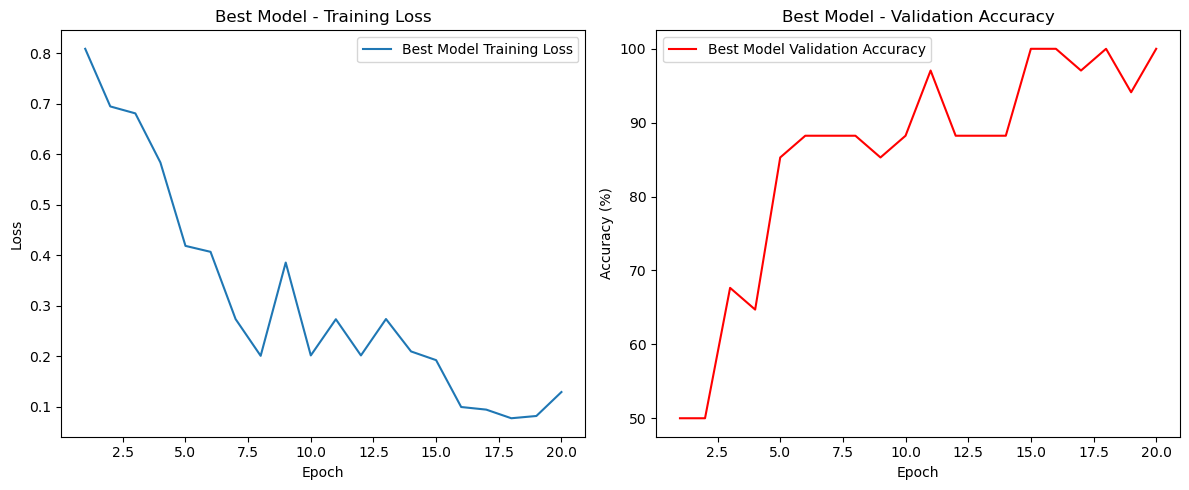

In [19]:
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
print(f"Best Hyperparameters: {best_hyperparams}")

# Plotting learning curves for the best model from hyperparameter search
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_search + 1), best_model_train_losses, label='Best Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Best Model - Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_search + 1), best_model_val_accuracies, label='Best Model Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Best Model - Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Load the best model state for further use if needed:
# model_best = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp, **best_hyperparams_arch).to(device)
# model_best.load_state_dict(best_model_state)
# where best_hyperparams_arch = {k: v for k,v in best_hyperparams.items() if k in ['conv1_out_channels', 'conv2_out_channels', 'fc_neurons']}

### Method 2 - Optuna

In [20]:
# %pip install optuna
# %pip install --upgrade pip

In [25]:
import optuna

# Device configuration
device = get_device()
print(f"Using device for Optuna hyperparameter tuning: {device}")

# Get image dimensions
sample_img, _ = train_dataset[0]
C, H, W = sample_img.shape
print(f"Image shape: Channels={C}, Height={H}, Width={W}")

num_classes_hp = 2
num_epochs_search = 20 # Fewer epochs for faster search, adjust as needed for Optuna trials
num_trials_optuna = 20 # Define number of trials

def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    conv1_out = trial.suggest_categorical("conv1_out_channels", [8, 16, 32, 64])
    conv2_out = trial.suggest_categorical("conv2_out_channels", [16, 32, 64, 128])
    fc_neurons_val = trial.suggest_categorical("fc_neurons", [64, 128, 256])

    # DataLoaders
    pin_memory_flag   = device.type == 'cuda'
    num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

    try:
        current_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
        current_val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag)
    except Exception as e:
        print(f"Error creating DataLoader for trial {trial.number}: {e}. Pruning trial.")
        raise optuna.exceptions.TrialPruned()


    # Model (Ensure SimpleCNN class is defined and accessible)
    model_opt = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
                          conv1_out_channels=conv1_out,
                          conv2_out_channels=conv2_out,
                          fc_neurons=fc_neurons_val).to(device)

    criterion_opt = nn.BCEWithLogitsLoss()
    optimizer_opt = optim.Adam(model_opt.parameters(), lr=lr)

    trial_train_losses = []
    trial_val_accuracies = []

    # Training loop
    for epoch in tqdm(range(num_epochs_search), desc=f"Trial {trial.number} [Training]", leave=False):
        model_opt.train()
        epoch_running_loss = 0.0
        for images, labels in current_train_loader: # train_pbar_opt:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer_opt.zero_grad(set_to_none=True)
            loss = criterion_opt(model_opt(images), labels)
            loss.backward()
            optimizer_opt.step()

            epoch_running_loss += loss.item() * images.size(0)

        trial_train_losses.append(epoch_running_loss / len(train_loader.dataset))

            # optimizer_opt.zero_grad()
        #     outputs = model_opt(images)
        #     loss = criterion_opt(outputs, labels)
        #     loss.backward()
        #     optimizer_opt.step()
        #     epoch_running_loss += loss.item() * images.size(0)
        
        # avg_epoch_train_loss = epoch_running_loss / len(current_train_loader.dataset)
        # trial_train_losses.append(avg_epoch_train_loss)

        # Validation
        model_opt.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in current_val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model_opt(images)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        current_epoch_val_accuracy = 100 * val_correct / val_total if val_total > 0 else 0
        trial_val_accuracies.append(current_epoch_val_accuracy)
        
        # Optuna pruning (optional, but good for long searches)
        trial.report(current_epoch_val_accuracy, epoch)
        if trial.should_prune():
            # Store partial curves if pruned
            trial.set_user_attr("train_losses", trial_train_losses)
            trial.set_user_attr("val_accuracies", trial_val_accuracies)
            raise optuna.exceptions.TrialPruned()

    # Store full learning curves in user attributes for the trial
    trial.set_user_attr("train_losses", trial_train_losses)
    trial.set_user_attr("val_accuracies", trial_val_accuracies)

    del model_opt, optimizer_opt, criterion_opt, current_train_loader, current_val_loader 
    if device.type == "mps":                                   
        torch.mps.empty_cache()
    elif device.type == "cuda":                                
        torch.cuda.empty_cache()
    gc.collect()   

    return trial_val_accuracies[-1] # Return final validation accuracy

# Create a study object and optimize
# You can add a pruner, e.g., optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=num_trials_optuna, gc_after_trial=True)

print("\nFinished Optuna Hyperparameter Search.")
best_trial_optuna = study.best_trial
best_hyperparams_optuna = best_trial_optuna.params
best_val_accuracy_optuna = best_trial_optuna.value


# Retrieve learning curves for the best trial
best_model_train_losses_optuna = best_trial_optuna.user_attrs.get("train_losses", [])
best_model_val_accuracies_optuna = best_trial_optuna.user_attrs.get("val_accuracies", [])

[I 2025-06-04 18:42:38,052] A new study created in memory with name: no-name-d61888a9-2daf-418a-a624-26d77c9a3cf2


Using device for Optuna hyperparameter tuning: mps
Image shape: Channels=3, Height=60, Width=30


Trial 0 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 18:47:10,769] Trial 0 finished with value: 50.0 and parameters: {'learning_rate': 0.00676468718250951, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 32, 'fc_neurons': 64}. Best is trial 0 with value: 50.0.


Trial 1 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 18:51:46,468] Trial 1 finished with value: 50.0 and parameters: {'learning_rate': 0.008671495486872547, 'batch_size': 32, 'conv1_out_channels': 8, 'conv2_out_channels': 16, 'fc_neurons': 128}. Best is trial 0 with value: 50.0.


Trial 2 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 18:56:21,085] Trial 2 finished with value: 50.0 and parameters: {'learning_rate': 0.0056161736195090356, 'batch_size': 16, 'conv1_out_channels': 32, 'conv2_out_channels': 64, 'fc_neurons': 64}. Best is trial 0 with value: 50.0.


Trial 3 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:00:56,560] Trial 3 finished with value: 50.0 and parameters: {'learning_rate': 0.0013857873867477422, 'batch_size': 8, 'conv1_out_channels': 64, 'conv2_out_channels': 128, 'fc_neurons': 128}. Best is trial 0 with value: 50.0.


Trial 4 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:05:40,759] Trial 4 finished with value: 50.0 and parameters: {'learning_rate': 0.00027375406447145955, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 128, 'fc_neurons': 256}. Best is trial 0 with value: 50.0.


Trial 5 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:10:22,503] Trial 5 finished with value: 50.0 and parameters: {'learning_rate': 0.0012155773726168862, 'batch_size': 32, 'conv1_out_channels': 32, 'conv2_out_channels': 32, 'fc_neurons': 64}. Best is trial 0 with value: 50.0.


Trial 6 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:15:09,866] Trial 6 finished with value: 50.0 and parameters: {'learning_rate': 0.00293861029199567, 'batch_size': 32, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 256}. Best is trial 0 with value: 50.0.


Trial 7 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:19:53,836] Trial 7 finished with value: 50.0 and parameters: {'learning_rate': 0.0005708854257773716, 'batch_size': 32, 'conv1_out_channels': 32, 'conv2_out_channels': 32, 'fc_neurons': 256}. Best is trial 0 with value: 50.0.


Trial 8 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:24:37,088] Trial 8 finished with value: 50.0 and parameters: {'learning_rate': 0.0002051440798183661, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 128, 'fc_neurons': 128}. Best is trial 0 with value: 50.0.


Trial 9 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:29:21,284] Trial 9 finished with value: 50.0 and parameters: {'learning_rate': 0.008176730901561746, 'batch_size': 32, 'conv1_out_channels': 64, 'conv2_out_channels': 128, 'fc_neurons': 256}. Best is trial 0 with value: 50.0.


Trial 10 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:34:06,195] Trial 10 finished with value: 50.0 and parameters: {'learning_rate': 0.0032419790117416023, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 16, 'fc_neurons': 64}. Best is trial 0 with value: 50.0.


Trial 11 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:38:49,417] Trial 11 finished with value: 50.0 and parameters: {'learning_rate': 0.009440398809160262, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 16, 'fc_neurons': 128}. Best is trial 0 with value: 50.0.


Trial 12 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:43:28,124] Trial 12 finished with value: 50.0 and parameters: {'learning_rate': 0.0029677034843899365, 'batch_size': 32, 'conv1_out_channels': 16, 'conv2_out_channels': 16, 'fc_neurons': 64}. Best is trial 0 with value: 50.0.


Trial 13 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:48:05,658] Trial 13 finished with value: 50.0 and parameters: {'learning_rate': 0.00480532747115043, 'batch_size': 8, 'conv1_out_channels': 16, 'conv2_out_channels': 64, 'fc_neurons': 128}. Best is trial 0 with value: 50.0.


Trial 14 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:52:45,665] Trial 14 finished with value: 50.0 and parameters: {'learning_rate': 0.00218258598350252, 'batch_size': 16, 'conv1_out_channels': 8, 'conv2_out_channels': 32, 'fc_neurons': 128}. Best is trial 0 with value: 50.0.


Trial 15 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 19:57:26,137] Trial 15 finished with value: 50.0 and parameters: {'learning_rate': 0.0007654442861150718, 'batch_size': 32, 'conv1_out_channels': 16, 'conv2_out_channels': 16, 'fc_neurons': 64}. Best is trial 0 with value: 50.0.


Trial 16 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 20:02:06,522] Trial 16 finished with value: 50.0 and parameters: {'learning_rate': 0.00010100222761492729, 'batch_size': 8, 'conv1_out_channels': 8, 'conv2_out_channels': 16, 'fc_neurons': 128}. Best is trial 0 with value: 50.0.


Trial 17 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

[W 2025-06-04 20:03:56,906] Trial 17 failed with parameters: {'learning_rate': 0.005316486859629714, 'batch_size': 8, 'conv1_out_channels': 64, 'conv2_out_channels': 32, 'fc_neurons': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/envs/DDAI_311/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/hm/4wbpsn2j6yx92hvp0rssd2lm0000gn/T/ipykernel_5469/2734463067.py", line 79, in objective
    for images, labels in current_val_loader: # val_pbar_opt:
  File "/opt/anaconda3/envs/DDAI_311/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 733, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/DDAI_311/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 789, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopI

KeyboardInterrupt: 

## Retrain best optuna model

In [ ]:
# After Optuna optimization, retrain the best model with the best hyperparameters and save it

# Extract best hyperparameters from the Optuna study
best_params = study.best_trial.params

# Dataloaders with the best batch size
pin_memory_flag   = device.type == 'cuda'
num_workers_flag  = 2 if device.type == 'cuda' else 0   # 0 on M-series/CPU

train_loader_opt = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=num_workers_flag, pin_memory=pin_memory_flag_opt)
val_loader_opt = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=num_workers_flag, pin_memory=pin_memory_flag_opt)

# Re-create and train the model with the best hyperparameters
model_optimal = SimpleCNN(
    input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
    conv1_out_channels=best_params['conv1_out_channels'],
    conv2_out_channels=best_params['conv2_out_channels'],
    fc_neurons=best_params['fc_neurons']
).to(device)

criterion_opt = nn.BCEWithLogitsLoss()
optimizer_opt = optim.Adam(model_optimal.parameters(), lr=best_params['learning_rate'])
num_epochs_opt = num_epochs_search  # Or set to a higher value for final training

for epoch in range(num_epochs_opt):
    model_optimal.train()
    for images, labels in train_loader_opt:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer_opt.zero_grad()
        outputs = model_optimal(images)
        loss = criterion_opt(outputs, labels)
        loss.backward()
        optimizer_opt.step()

# Save the trained optimal model
best_optuna_model_path = "best_optuna_cnn_model.pth"
torch.save(model_optimal.state_dict(), best_optuna_model_path)
print(f"Optimal model saved to {best_optuna_model_path}")


Optimal model saved to best_optuna_cnn_model.pth


#### Plots

Best Validation Accuracy (from Optuna study): 61.76%
Best Hyperparameters (from Optuna study): {'learning_rate': 0.001553369838635351, 'batch_size': 32, 'conv1_out_channels': 16, 'conv2_out_channels': 16, 'fc_neurons': 256}


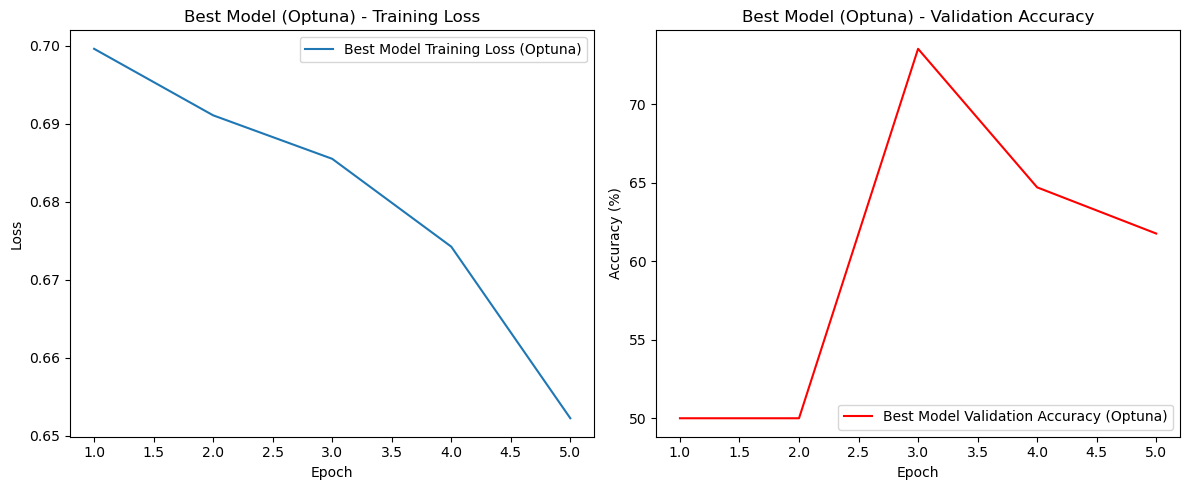

In [ ]:
print(f"Best Validation Accuracy (from Optuna study): {best_val_accuracy_optuna:.2f}%")
print(f"Best Hyperparameters (from Optuna study): {best_hyperparams_optuna}")

# Plotting learning curves for the best model from Optuna hyperparameter search
if best_model_train_losses_optuna and best_model_val_accuracies_optuna:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(best_model_train_losses_optuna) + 1), best_model_train_losses_optuna, label='Best Model Training Loss (Optuna)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Best Model (Optuna) - Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(best_model_val_accuracies_optuna) + 1), best_model_val_accuracies_optuna, label='Best Model Validation Accuracy (Optuna)', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Best Model (Optuna) - Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data for the best Optuna trial is not available.")
    
# You can now load the best model state for further use if needed.
# First, you'd typically retrain a model with best_hyperparams_optuna for a full number of epochs
# and save its state_dict. The state_dict is not directly saved by the Optuna objective function above.
# Example:
# model_best_optuna = SimpleCNN(input_channels=C, input_height=H, input_width=W, num_classes=num_classes_hp,
#                               conv1_out_channels=best_hyperparams_optuna['conv1_out_channels'],
#                               conv2_out_channels=best_hyperparams_optuna['conv2_out_channels'],
#                               fc_neurons=best_hyperparams_optuna['fc_neurons']).to(device)
# # Then, you would train this model_best_optuna using the best learning rate, optimizer, and batch size.
# # For now, we are just plotting the curves from the optimization search itself.